# Assignment 3: Titanic problem, Nicholas Petr, MSCA 31008 5 Data Mining Principles

Resources:

https://www.kaggle.com/startupsci/titanic-data-science-solutions

https://www.analyticsvidhya.com/blog/2022/01/diabetes-prediction-using-machine-learning/

## Load packages and training dataset

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import pickle
# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('train.csv')

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Check null values in dataset.

### We see that Cabin is largely empty, meaning it is most likely beyond the point of imputation. Age is missing some values, but will likely be an important variable, so we will use imputation. 

In [3]:
len(df)

891

In [4]:
# check the number of null values our dataset has.
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

## Review columns where we are unclear about what value is being provided to determine what can be dropped from the dataset

### Ticket is largely unique, so we can go ahead and remove 

In [5]:
len(df['Ticket'].unique())

681

### Embarked is largely populated and does look to have some impact on survival rate, so we will keep

In [6]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [7]:
def grid(x_var):
    sns.set(style="whitegrid")
    g = sns.PairGrid(data=df, x_vars=[x_var], y_vars='Survived', size=5)
    g.map(sns.pointplot, color=sns.xkcd_rgb["red"])
    g.set(ylim=(0, 1))

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1152: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


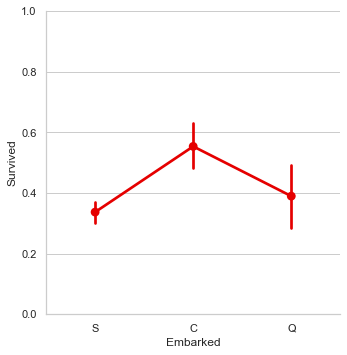

In [8]:
grid('Embarked')

## Drop fields that will not provide value in determining survival rate after initial assessment 

In [9]:
df.drop(['Name', 'PassengerId', 'Cabin', 'Ticket'], axis=1, inplace=True)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


## Analyze remaining columns and incorporate new columns based on what may provide additional support to the models

### Plotting the data distribution plots

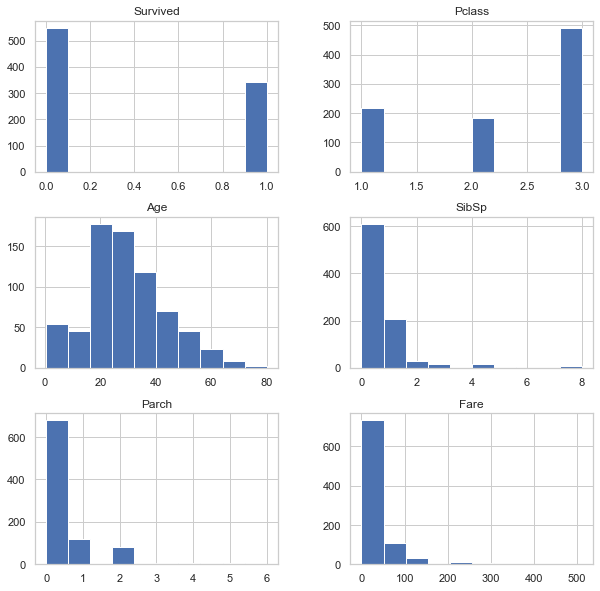

In [10]:
p = df.hist(figsize = (10,10))

## Age

### Imputing the mean value of the age column to each missing value of that particular column

In [11]:
df['Age'].fillna(df['Age'].mean(), inplace = True)

### Generate ageGroup column that indicates child, adult, or senior

In [12]:
df.loc[df['Age']<=15, 'ageGroup'] = 1
df.loc[df['Age'].between(16,59), 'ageGroup'] = 2
df.loc[df['Age']>=60, 'ageGroup'] = 3

df.head(20)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,ageGroup
0,0,3,male,22.000000,1,0,7.2500,S,2.0
1,1,1,female,38.000000,1,0,71.2833,C,2.0
2,1,3,female,26.000000,0,0,7.9250,S,2.0
3,1,1,female,35.000000,1,0,53.1000,S,2.0
4,0,3,male,35.000000,0,0,8.0500,S,2.0
5,0,3,male,29.699118,0,0,8.4583,Q,2.0
6,0,1,male,54.000000,0,0,51.8625,S,2.0
7,0,3,male,2.000000,3,1,21.0750,S,1.0
8,1,3,female,27.000000,0,2,11.1333,S,2.0
9,1,2,female,14.000000,1,0,30.0708,C,1.0


### Age groupings selected because it appeared to have largest impact on survival rate 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1152: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


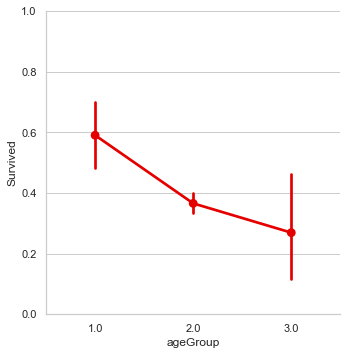

In [13]:
grid('ageGroup')

# Fare

### Create indicator for passangers who have a high associated fare

In [14]:
df['Fare'].value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
50.4958     1
13.8583     1
8.4583      1
7.7250      1
7.5208      1
Name: Fare, Length: 248, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1152: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


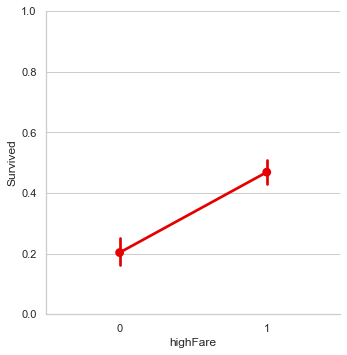

In [15]:
df['highFare'] = np.where(df['Fare']>8.0500, 1, 0)
grid('highFare')

## Add Family variable and isAlone variable

In [16]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1152: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


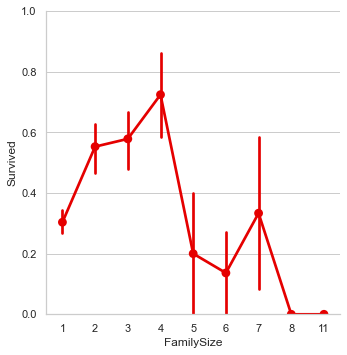

In [17]:
grid('FamilySize')

In [18]:
df['isAlone'] = np.where(df['FamilySize']==1, 1, 0)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1152: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(UserWarning(msg))


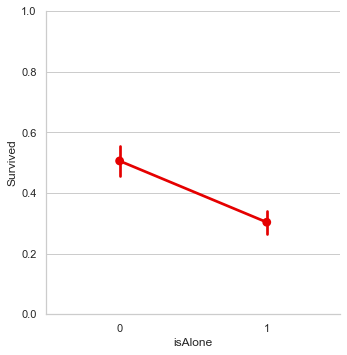

In [19]:
grid('isAlone')

## Embarked 

### Fill na values in Embarked with S categorization, which is most common occurance

In [20]:
df["Embarked"].fillna("S", inplace = True)
df['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

## Convert categorical variables to numeric variables 

In [21]:
df['Sex'].replace(['male', 'female'],
                        [0, 1], inplace=True)

In [22]:
df['Embarked'].replace(['S', 'C', 'Q'],
                        [0, 1, 2], inplace=True)

## Review updated dataset

In [23]:
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,ageGroup,highFare,FamilySize,isAlone
0,0,3,0,22.0,1,0,7.2500,0,2.0,0,2,0
1,1,1,1,38.0,1,0,71.2833,1,2.0,1,2,0
2,1,3,1,26.0,0,0,7.9250,0,2.0,0,1,1
3,1,1,1,35.0,1,0,53.1000,0,2.0,1,2,0
4,0,3,0,35.0,0,0,8.0500,0,2.0,0,1,1


### Confirm there are no null values

In [24]:
df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
ageGroup      0
highFare      0
FamilySize    0
isAlone       0
dtype: int64

### Plot updated distributions

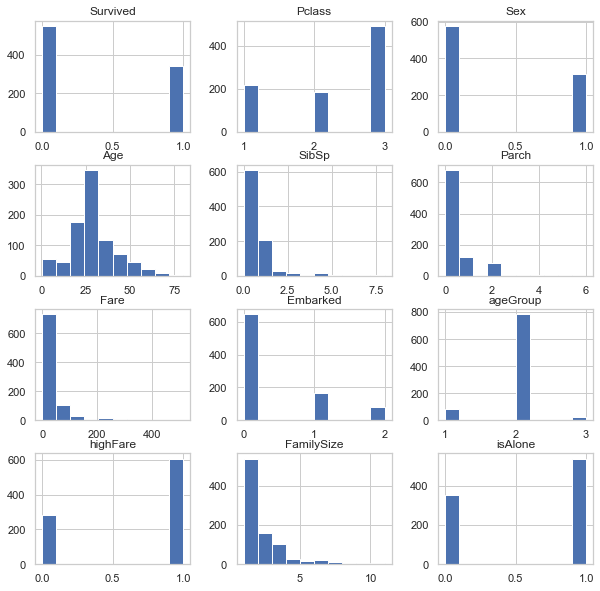

In [25]:
p = df.hist(figsize = (10,10))

## Remove survived variable and use standard scaling on remaining columns 

In [26]:
# Conduct Standard Scaling 
sc_X = StandardScaler()
X =  pd.DataFrame(sc_X.fit_transform(df.drop(["Survived"],axis = 1),), columns=['Pclass', 
'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'ageGroup',
'highFare', 'FamilySize', 'isAlone'])
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,ageGroup,highFare,FamilySize,isAlone
0,0.827377,-0.737695,-0.592481,0.432793,-0.473674,-0.502445,-0.568837,0.186042,-1.458189,0.059160,-1.231645
1,-1.566107,1.355574,0.638789,0.432793,-0.473674,0.786845,1.005181,0.186042,0.685782,0.059160,-1.231645
2,0.827377,1.355574,-0.284663,-0.474545,-0.473674,-0.488854,-0.568837,0.186042,-1.458189,-0.560975,0.811922
3,-1.566107,1.355574,0.407926,0.432793,-0.473674,0.420730,-0.568837,0.186042,0.685782,0.059160,-1.231645
4,0.827377,-0.737695,0.407926,-0.474545,-0.473674,-0.486337,-0.568837,0.186042,-1.458189,-0.560975,0.811922


### Establish target outcome variable for training set

In [27]:
# Establish Target Outcome Variable 
y = df.Survived
y

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

# Model Builing: This is where you create your test and train samples, which we fit with a number of different model types to find the best results

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33,
                                                    random_state=7)

# For each model, we will produce, train and apply the model to our train and test sets to generate scores. We will review the classification report and model score, as the goal is to have a high accuracy score as well as a high F1 score

## Random Forrest 

In [29]:
# Produce and save the model, then load and apply the model.
rfc = RandomForestClassifier(n_estimators=1500)
rfc.fit(X_train, y_train)
rfc_predictions = rfc.predict(X_test)
print(classification_report(y_test,rfc_predictions))
rfc_score = round(rfc.score(X_test, y_test) * 100, 2)
rfc_score

              precision    recall  f1-score   support

           0       0.78      0.85      0.82       176
           1       0.75      0.65      0.69       119

    accuracy                           0.77       295
   macro avg       0.76      0.75      0.75       295
weighted avg       0.77      0.77      0.77       295



76.95

### Review feature analysis. We will use this information to see if reduction of variables helps improve scoring for one of our higher-scoring models

<AxesSubplot:>

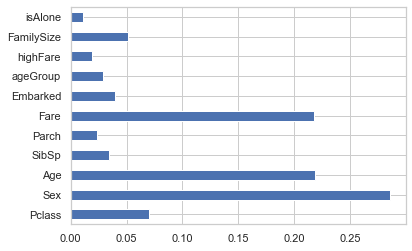

In [30]:
(pd.Series(rfc.feature_importances_, index=X.columns).plot(kind='barh'))

## Logistic Regression

In [31]:
# Produce and save the model, then load and apply the model.
lrc = LogisticRegression()
lrc.fit(X_train, y_train)
lrc_predictions = lrc.predict(X_test)
print(classification_report(y_test,lrc_predictions))
lrc_score = round(lrc.score(X_test, y_test) * 100, 2)
lrc_score

              precision    recall  f1-score   support

           0       0.79      0.86      0.82       176
           1       0.76      0.66      0.71       119

    accuracy                           0.78       295
   macro avg       0.78      0.76      0.77       295
weighted avg       0.78      0.78      0.78       295



77.97

## Linear SVC 

In [32]:
# Produce and save the model, then load and apply the model.
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)
lsvc_predictions = lsvc.predict(X_test)
print(classification_report(y_test,lsvc_predictions))
lsvc_score = round(lsvc.score(X_test, y_test) * 100, 2)
lsvc_score

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       176
           1       0.75      0.65      0.70       119

    accuracy                           0.77       295
   macro avg       0.77      0.75      0.76       295
weighted avg       0.77      0.77      0.77       295



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


77.29

## SVC

In [33]:
svcR = SVC()
svcR.fit(X_train, y_train)
svcR_predictions = svcR.predict(X_test)
print(classification_report(y_test,svcR_predictions))
svcR_score = round(svcR.score(X_test, y_test) * 100, 2)
svcR_score

              precision    recall  f1-score   support

           0       0.78      0.88      0.83       176
           1       0.78      0.64      0.70       119

    accuracy                           0.78       295
   macro avg       0.78      0.76      0.76       295
weighted avg       0.78      0.78      0.78       295



77.97

## Nearest Neighbors 

In [34]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)
print(classification_report(y_test,knn_predictions))
knn_score = round(knn.score(X_test, y_test) * 100, 2)
knn_score

              precision    recall  f1-score   support

           0       0.76      0.83      0.79       176
           1       0.71      0.61      0.65       119

    accuracy                           0.74       295
   macro avg       0.73      0.72      0.72       295
weighted avg       0.74      0.74      0.73       295



73.9

## Decision Tree

In [35]:
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
dtree_predictions = dtree.predict(X_test)
print(classification_report(y_test,dtree_predictions))
dtree_score = round(dtree.score(X_test, y_test) * 100, 2)
dtree_score

              precision    recall  f1-score   support

           0       0.73      0.81      0.77       176
           1       0.66      0.56      0.61       119

    accuracy                           0.71       295
   macro avg       0.70      0.68      0.69       295
weighted avg       0.70      0.71      0.70       295



70.85

## Naive Bayes

In [36]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_predictions = gnb.predict(X_test)
print(classification_report(y_test,gnb_predictions))
gnb_score = round(gnb.score(X_test, y_test) * 100, 2)
gnb_score

              precision    recall  f1-score   support

           0       0.81      0.84      0.83       176
           1       0.75      0.71      0.73       119

    accuracy                           0.79       295
   macro avg       0.78      0.78      0.78       295
weighted avg       0.79      0.79      0.79       295



78.98

## Perceptron

In [37]:
per = Perceptron()
per.fit(X_train, y_train)
per_predictions = per.predict(X_test)
print(classification_report(y_test,per_predictions))
per_score = round(per.score(X_test, y_test) * 100, 2)
per_score

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       176
           1       0.76      0.64      0.69       119

    accuracy                           0.77       295
   macro avg       0.77      0.75      0.76       295
weighted avg       0.77      0.77      0.77       295



77.29

## SGD Classifier

In [38]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
sgd_predictions = sgd.predict(X_test)
print(classification_report(y_test,sgd_predictions))
sgd_score = round(sgd.score(X_test, y_test) * 100, 2)
sgd_score

              precision    recall  f1-score   support

           0       0.73      0.85      0.79       176
           1       0.71      0.53      0.61       119

    accuracy                           0.72       295
   macro avg       0.72      0.69      0.70       295
weighted avg       0.72      0.72      0.71       295



72.2

## Gradient Boosting Classifier 

In [39]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)
gbc_predictions = gbc.predict(X_test)
print(classification_report(y_test,gbc_predictions))
gbc_score = round(gbc.score(X_test, y_test) * 100, 2)
gbc_score

              precision    recall  f1-score   support

           0       0.78      0.89      0.83       176
           1       0.80      0.63      0.70       119

    accuracy                           0.79       295
   macro avg       0.79      0.76      0.77       295
weighted avg       0.79      0.79      0.78       295



78.64

## XG Boost 

In [40]:
xgbc = XGBClassifier()
xgbc.fit(X_train, y_train)
xgbc_predictions = xgbc.predict(X_test)
print(classification_report(y_test,xgbc_predictions))
xgbc_score = round(xgbc.score(X_test, y_test) * 100, 2)
xgbc_score

[20:18:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.79      0.87      0.83       176
           1       0.77      0.66      0.71       119

    accuracy                           0.78       295
   macro avg       0.78      0.76      0.77       295
weighted avg       0.78      0.78      0.78       295



C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


78.31

##  select top 3, try them with non-scaled variables and reduced dimmensions (via random forest bar chart), see if there is anything to improve score within each model, pickle, run through test data, end. DO NOT SPEND TOO MUCH TIME 

In [41]:
models = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression', 'Linear SVC', 'Support Vector Machines', 'Nearest Neighbors',
             'Decision Tree', 'GNB', 'Perceptron', 'SGD', 'Gradient Boosting', "XGBoosting"],
    
    'Score': [rfc_score, lrc_score, lsvc_score, svcR_score, knn_score, dtree_score, gnb_score, 
              per_score, sgd_score, gbc_score, xgbc_score]
    })

models.sort_values(by='Score', ascending=False)

,Model,Score
6,GNB,78.98
9,Gradient Boosting,78.64
10,XGBoosting,78.31
1,Logistic Regression,77.97
3,Support Vector Machines,77.97
2,Linear SVC,77.29
7,Perceptron,77.29
0,Random Forest,76.95
4,Nearest Neighbors,73.90
8,SGD,72.20


# GNB, Gradient Boosting, and XGBoosting return the best initial scores. We will now attempt a few additional adjustments for these three top models to see if the score can be improved 

## Review model scores using SMOTE analysis to determine if imbalanced survival rate may be impacting our score 

In [42]:
oversampler=SMOTE(random_state=7)
os_features,os_labels=oversampler.fit_sample(X_train,y_train)

## We see below that SMOTE improves our GNB score

In [43]:
SMOTE_gnb = GaussianNB()
SMOTE_gnb.fit(os_features, os_labels)
SMOTE_gnb_predictions = SMOTE_gnb.predict(X_test)
print(classification_report(y_test,SMOTE_gnb_predictions))
SMOTE_gnb_score = round(SMOTE_gnb.score(X_test, y_test) * 100, 2)
SMOTE_gnb_score

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       176
           1       0.75      0.73      0.74       119

    accuracy                           0.79       295
   macro avg       0.79      0.78      0.78       295
weighted avg       0.79      0.79      0.79       295



79.32

## SMOTE improves our Gradient Boosting score to above 80%

In [44]:
SMOTE_gbc = GradientBoostingClassifier()
SMOTE_gbc.fit(os_features, os_labels)
SMOTE_gbc_predictions = SMOTE_gbc.predict(X_test)
print(classification_report(y_test,SMOTE_gbc_predictions))
SMOTE_gbc_score = round(SMOTE_gbc.score(X_test, y_test) * 100, 2)
SMOTE_gbc_score

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       176
           1       0.82      0.67      0.74       119

    accuracy                           0.81       295
   macro avg       0.81      0.79      0.80       295
weighted avg       0.81      0.81      0.81       295



81.02

## SMOTE lowers our XBoosting Score

In [45]:
SMOTE_xgbc = XGBClassifier()
SMOTE_xgbc.fit(os_features, os_labels)
SMOTE_xgbc_predictions = SMOTE_xgbc.predict(X_test)
print(classification_report(y_test,SMOTE_xgbc_predictions))
SMOTE_xgbc_score = round(SMOTE_xgbc.score(X_test, y_test) * 100, 2)
SMOTE_xgbc_score

[20:18:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       176
           1       0.75      0.68      0.71       119

    accuracy                           0.78       295
   macro avg       0.77      0.76      0.77       295
weighted avg       0.78      0.78      0.78       295



C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


77.97

# Save the SMOTE Gradient Boosting Model with the best output by using pickle. 

In [46]:
# Firstly we will be using the dump() function to save the model using pickle
saved_model = pickle.dumps(SMOTE_gbc)

# Then we will be loading that saved model
SMOTE_gbc_from_pickle = pickle.loads(saved_model)

# lastly, after loading that model we will use this to make predictions
SMOTE_gbc_from_pickle.predict(X_test)

array([0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1], dtype=int64)

# Incorporation of Test Data

In [47]:
test_df = pd.read_csv('holdout_test.csv')
test_df.head()

,Survived,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,NaN,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,NaN,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,NaN,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,NaN,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,NaN,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [48]:
# check the number of null values our dataset has.
test_df.isnull().sum()

Survived       418
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

### Conduct cleaning and preprocessing 

In [49]:
test_df.drop(['Name', 'PassengerId', 'Cabin', 'Ticket'], axis=1, inplace=True)

In [50]:
test_df['Age'].fillna(test_df['Age'].mean(), inplace = True)

In [51]:
# Median instead of mean, as outlier fare rates may cause issue
test_df['Fare'].fillna(test_df['Age'].median(), inplace = True)

In [52]:
test_df.loc[test_df['Age']<=15, 'ageGroup'] = 1
test_df.loc[test_df['Age'].between(16,59), 'ageGroup'] = 2
test_df.loc[test_df['Age']>=60, 'ageGroup'] = 3

In [53]:
test_df['highFare'] = np.where(test_df['Fare']>8.0500, 1, 0)

In [54]:
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

In [55]:
test_df['isAlone'] = np.where(test_df['FamilySize']==1, 1, 0)

In [56]:
test_df['Sex'].replace(['male', 'female'],
                        [0, 1], inplace=True)

In [57]:
test_df['Embarked'].replace(['S', 'C', 'Q'],
                        [0, 1, 2], inplace=True)

In [58]:
test_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,ageGroup,highFare,FamilySize,isAlone
0,NaN,3,0,34.5,0,0,7.8292,2,2.0,0,1,1
1,NaN,3,1,47.0,1,0,7.0000,0,2.0,0,2,0
2,NaN,2,0,62.0,0,0,9.6875,2,3.0,1,1,1
3,NaN,3,0,27.0,0,0,8.6625,0,2.0,1,1,1
4,NaN,3,1,22.0,1,1,12.2875,0,2.0,1,3,0


In [59]:
test_df.isnull().sum()

Survived      418
Pclass          0
Sex             0
Age             0
SibSp           0
Parch           0
Fare            0
Embarked        0
ageGroup        0
highFare        0
FamilySize      0
isAlone         0
dtype: int64

In [60]:
# Conduct Standard Scaling 
sc_X_test = StandardScaler()
X_final =  pd.DataFrame(sc_X_test.fit_transform(test_df.drop(["Survived"],axis = 1),), columns=['Pclass', 
'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'ageGroup',
'highFare', 'FamilySize', 'isAlone'])
X_final.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,ageGroup,highFare,FamilySize,isAlone
0,0.873482,-0.755929,0.334993,-0.499470,-0.400248,-0.498172,2.243165,0.130917,-1.439975,-0.553443,0.807573
1,0.873482,1.322876,1.325530,0.616992,-0.400248,-0.513039,-0.677841,0.130917,-1.439975,0.105643,-1.238278
2,-0.315819,-0.755929,2.514175,-0.499470,-0.400248,-0.464854,2.243165,3.171098,0.694456,-0.553443,0.807573
3,0.873482,-0.755929,-0.259330,-0.499470,-0.400248,-0.483231,-0.677841,0.130917,0.694456,-0.553443,0.807573
4,0.873482,1.322876,-0.655545,0.616992,0.619896,-0.418237,-0.677841,0.130917,0.694456,0.764728,-1.238278


# Once we have cleaned test data exactly like data used to train/test model, we apply Gradient Boosting model on it

In [61]:
# lastly, after loading that model we will use this to make predictions
survivedOutput = SMOTE_gbc_from_pickle.predict(X_final)

In [62]:
survivedOutput

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

# Finally, we merge it back in with the holdout dataset as a model predicted value column

In [63]:
export = pd.DataFrame(survivedOutput, columns=['SurvivedModelOutput']) 

In [64]:
export.head(9)

,SurvivedModelOutput
0,0
1,0
2,0
3,0
4,0
5,0
6,1
7,0
8,1


In [65]:
holdout_test = pd.read_csv('holdout_test.csv')

In [66]:
df_export = holdout_test.join(export)
df_export.head(9)

,Survived,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,SurvivedModelOutput
0,NaN,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,NaN,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,NaN,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,NaN,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,NaN,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0
5,NaN,897,3,"Svensson, Mr. Johan Cervin",male,14.0,0,0,7538,9.2250,NaN,S,0
6,NaN,898,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,NaN,Q,1
7,NaN,899,2,"Caldwell, Mr. Albert Francis",male,26.0,1,1,248738,29.0000,NaN,S,0
8,NaN,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",female,18.0,0,0,2657,7.2292,NaN,C,1


In [67]:
# df_export.to_csv(r"C:\Users\Nick's Laptop\Desktop\Data Mining Principles\assignment-3\Titanic Survival\Titanic Results from_Nicholas_Petr.csv", sep=',')